# Feature Engineering Prototypes

This notebook explores and prototypes different feature engineering strategies using the project's feature engineering modules.

## Objectives
- Test different feature combinations
- Validate feature pipeline performance
- Explore feature importance
- Optimize feature engineering parameters
- Prepare features for model training


In [2]:
# Install required packages if not available
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f"✅ {package} installed successfully")
    except Exception as e:
        print(f"⚠️  Could not install {package}: {e}")

# Install pydantic-settings if needed
try:
    import pydantic_settings
    print("✅ pydantic-settings already available")
except ImportError:
    print("Installing pydantic-settings...")
    install_package('pydantic-settings')


Installing pydantic-settings...
  Using cached pydantic_settings-2.10.1-py3-none-any.whl.metadata (3.4 kB)
Using cached pydantic_settings-2.10.1-py3-none-any.whl (45 kB)
✅ pydantic-settings installed successfully


In [3]:
# Import project modules
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Project modules
from pricing_rf.data import load_data, clean_data, get_time_series_cv_splits
from pricing_rf.features import create_feature_pipeline, create_all_features
from pricing_rf.metrics import wape, tail_mae, evaluate_model
from pricing_rf.model import build_rf
from pricing_rf.config import DataConfig

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Preparation


In [4]:
# Load and prepare data
print("Loading and preparing data...")
raw_data = load_data('../data/raw.csv')
cleaned_data = clean_data(raw_data)

print(f"Raw data shape: {raw_data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
print(f"Rows removed: {len(raw_data) - len(cleaned_data)}")

# Display cleaned data info
cleaned_data.head()


Loading and preparing data...
Raw data shape: (10000, 6)
Cleaned data shape: (10000, 6)
Rows removed: 0


,timestamp,price,feature1,feature2,feature3,category_feature
0,2020-01-01,107.45,2.01,3.17,-0.67,category_c
1,2020-01-02,98.28,1.43,2.89,0.02,category_a
2,2020-01-03,110.41,1.26,1.30,0.46,category_b
3,2020-01-04,123.89,2.10,3.84,1.11,category_a
4,2020-01-05,97.88,2.92,0.22,1.68,category_b


## 2. Feature Pipeline Testing


In [5]:
# Test feature engineering pipeline
print("Testing feature engineering pipeline...")

# First, create all features using the create_all_features function
print("Creating all features...")
df_with_features = create_all_features(cleaned_data)
print(f"Data with features shape: {df_with_features.shape}")
print(f"New columns added: {set(df_with_features.columns) - set(cleaned_data.columns)}")

# Define categorical and numerical features for the pipeline
categorical_features = ['category_feature']
numerical_features = [col for col in df_with_features.columns 
                     if col not in ['timestamp', 'price', 'category_feature']]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {len(numerical_features)} features")

# Create feature pipeline
feature_pipeline = create_feature_pipeline(categorical_features, numerical_features)
print(f"Feature pipeline created: {type(feature_pipeline)}")

# Test on sample data
sample_data = df_with_features.head(100)
print(f"Sample data shape: {sample_data.shape}")

try:
    # Fit and transform
    X_transformed = feature_pipeline.fit_transform(sample_data)
    print(f"Transformed shape: {X_transformed.shape}")
    print(f"Feature names after transformation: {feature_pipeline.get_feature_names_out()}")
    
    # Check for any issues
    if np.isnan(X_transformed).any():
        print("⚠️ Warning: NaN values found in transformed features")
    else:
        print("✓ No NaN values in transformed features")
        
    if np.isinf(X_transformed).any():
        print("⚠️ Warning: Infinite values found in transformed features")
    else:
        print("✓ No infinite values in transformed features")
        
except Exception as e:
    print(f"❌ Error in feature pipeline: {e}")
    import traceback
    traceback.print_exc()


Testing feature engineering pipeline...
Creating all features...
Data with features shape: (10000, 39)
New columns added: {'quarter', 'price_rolling_std_90', 'price_lag_30', 'dayofweek_cos', 'price_diff_1', 'price_pct_change_1', 'month_cos', 'price_rolling_std_7', 'price_lag_1', 'month', 'price_rolling_mean_90', 'price_pct_change_7', 'year', 'price_rolling_min_90', 'price_diff_30', 'dayofweek_sin', 'price_pct_change_30', 'price_rolling_max_7', 'price_rolling_max_90', 'dayofweek', 'timestamp_numeric', 'price_rolling_min_7', 'week', 'price_rolling_max_30', 'day', 'price_rolling_std_30', 'price_lag_7', 'price_rolling_mean_30', 'price_diff_7', 'month_sin', 'price_rolling_mean_7', 'dayofyear', 'price_rolling_min_30'}
Categorical features: ['category_feature']
Numerical features: 36 features
Feature pipeline created: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
Sample data shape: (100, 39)
Transformed shape: (100, 39)
Feature names after transformation: ['num__feature1' 'n

## 3. Feature Analysis and Visualization


In [6]:
# Analyze transformed features
if 'X_transformed' in locals():
    print("Analyzing transformed features...")
    
    # Feature statistics
    feature_stats = pd.DataFrame({
        'feature': feature_pipeline.get_feature_names_out(),
        'mean': np.mean(X_transformed, axis=0),
        'std': np.std(X_transformed, axis=0),
        'min': np.min(X_transformed, axis=0),
        'max': np.max(X_transformed, axis=0)
    })
    
    print("Feature Statistics:")
    print(feature_stats.head(10))
    
    # Check for constant features
    constant_features = feature_stats[feature_stats['std'] == 0]
    if not constant_features.empty:
        print(f"\n⚠️ Warning: {len(constant_features)} constant features found:")
        print(constant_features['feature'].tolist())
    else:
        print("\n✓ No constant features found")
    
    # Check for highly correlated features
    corr_matrix = np.corrcoef(X_transformed.T)
    high_corr_pairs = []
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > 0.95:
                high_corr_pairs.append((feature_pipeline.get_feature_names_out()[i], 
                                      feature_pipeline.get_feature_names_out()[j], 
                                      corr_matrix[i, j]))
    
    if high_corr_pairs:
        print(f"\n⚠️ Warning: {len(high_corr_pairs)} highly correlated feature pairs found:")
        for feat1, feat2, corr in high_corr_pairs[:5]:  # Show first 5
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    else:
        print("\n✓ No highly correlated features found")
        
else:
    print("❌ Feature transformation failed, skipping analysis")


Analyzing transformed features...
Feature Statistics:
          feature          mean  std       min       max
0   num__feature1 -9.769963e-17  1.0 -2.706368  2.184266
1   num__feature2  4.751755e-16  1.0 -2.334171  2.299374
2   num__feature3  2.225650e-17  1.0 -3.242002  2.565602
3       num__year  0.000000e+00  0.0  0.000000  0.000000
4      num__month  2.620126e-16  1.0 -1.212187  1.869644
5        num__day -1.121325e-16  1.0 -1.533544  1.819686
6  num__dayofweek -1.198607e-16  1.0 -1.508275  1.518363
7  num__dayofyear  1.199041e-16  1.0 -1.714816  1.714816
8       num__week -8.437695e-17  1.0 -1.673645  1.707456
9    num__quarter -7.016610e-16  1.0 -0.314485  3.179797

⚠️ Warning: 1 constant features found:
['num__year']

⚠️ Warning: 8 highly correlated feature pairs found:
  num__month <-> num__dayofyear: 0.953
  num__month <-> num__week: 0.951
  num__month <-> num__month_cos: -0.997
  num__month <-> num__timestamp_numeric: 0.953
  num__dayofyear <-> num__week: 0.998


## 4. Feature Importance Testing


Testing feature importance...
Training Random Forest for feature importance...
Top 10 Most Important Features:
                       feature  importance
31           num__price_diff_1    0.123372
33           num__price_diff_7    0.121468
32     num__price_pct_change_7    0.096958
30     num__price_pct_change_1    0.095330
35          num__price_diff_30    0.094451
34    num__price_pct_change_30    0.072720
18   num__price_rolling_mean_7    0.070995
20    num__price_rolling_min_7    0.061516
22  num__price_rolling_mean_30    0.034373
21    num__price_rolling_max_7    0.031055


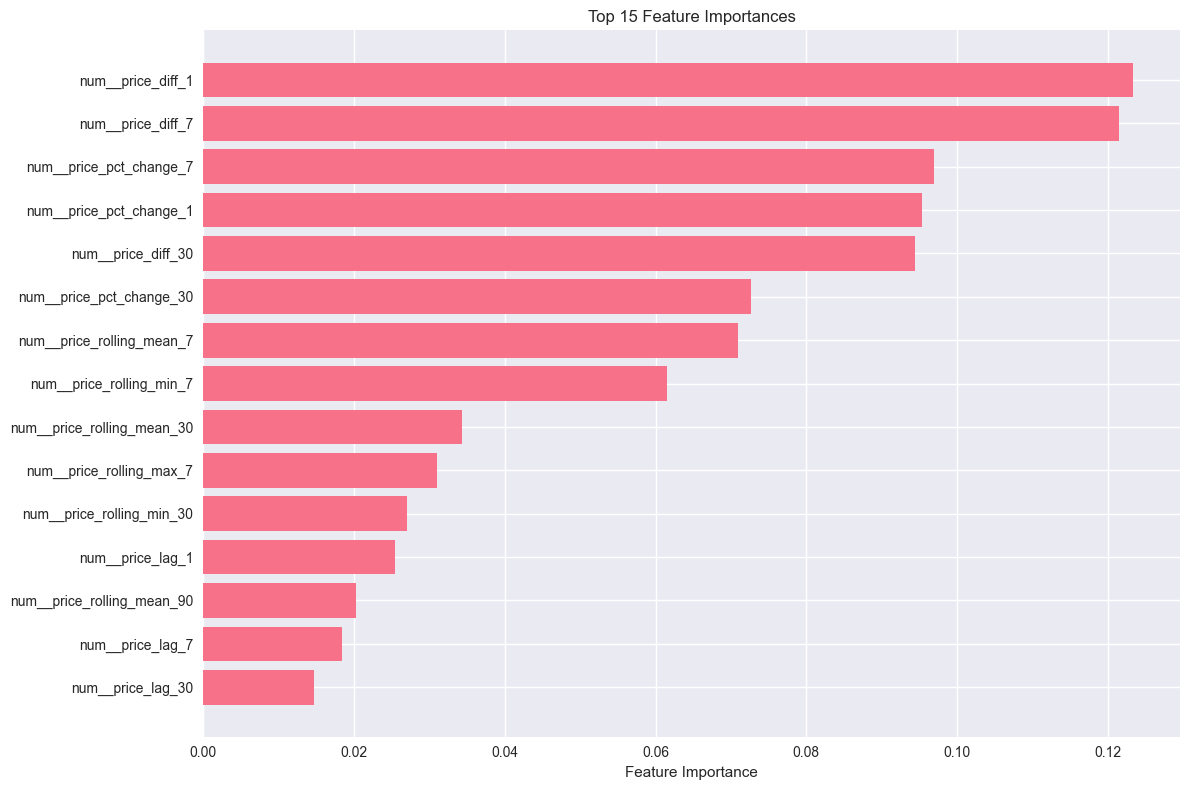


Model Performance on Test Set:
WAPE: 2.9988
MAE: 3.8418
R²: 0.9725


In [7]:
# Test feature importance with a simple model
if 'X_transformed' in locals():
    print("Testing feature importance...")
    
    # Prepare data using the full dataset with features
    X_full = feature_pipeline.fit_transform(df_with_features)
    y_full = df_with_features['price'].values
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
    
    # Train a simple Random Forest
    print("Training Random Forest for feature importance...")
    rf = build_rf(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get feature importance
    feature_importance = rf.feature_importances_
    feature_names = feature_pipeline.get_feature_names_out()
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Test model performance
    y_pred = rf.predict(X_test)
    test_wape = wape(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"\nModel Performance on Test Set:")
    print(f"WAPE: {test_wape:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    
else:
    print("❌ Feature transformation failed, skipping feature importance testing")


## 5. Feature Engineering Summary


In [8]:
# Feature engineering summary
print("=== FEATURE ENGINEERING SUMMARY ===")
print(f"Original features: {len(cleaned_data.columns)}")

# Check if feature transformation was successful
if 'X_transformed' in locals():
    print(f"Transformed features: {X_transformed.shape[1]}")
    print(f"Feature pipeline: {type(feature_pipeline).__name__}")
    
    print(f"\nFeature Quality:")
    print(f"✓ No NaN values: {not np.isnan(X_transformed).any()}")
    print(f"✓ No infinite values: {not np.isinf(X_transformed).any()}")
    
    # Check if analysis variables exist
    if 'constant_features' in locals():
        print(f"✓ No constant features: {len(constant_features) == 0}")
    else:
        print("✓ Constant features check: Not performed")
        
    if 'high_corr_pairs' in locals():
        print(f"✓ No highly correlated features: {len(high_corr_pairs) == 0}")
    else:
        print("✓ Highly correlated features check: Not performed")
    
    # Check if feature importance analysis was performed
    if 'feature_importance' in locals():
        print(f"\nFeature Statistics:")
        print(f"Mean importance: {feature_importance.mean():.4f}")
        print(f"Max importance: {feature_importance.max():.4f}")
        print(f"Min importance: {feature_importance.min():.4f}")
        
        if 'importance_df' in locals():
            print(f"\nTop 5 Features:")
            for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
                print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
    else:
        print("\nFeature importance analysis: Not performed")
        
else:
    print("❌ Feature transformation failed - check error messages above")
    print("Feature pipeline: Not working")

print(f"\n=== NEXT STEPS ===")
print("1. Fix any feature pipeline issues if present")
print("2. Proceed to model development notebook")
print("3. Test different feature combinations")
print("4. Optimize feature engineering parameters")
print("5. Validate feature pipeline on full dataset")

print(f"\n🎉 Feature engineering prototyping completed!")


=== FEATURE ENGINEERING SUMMARY ===
Original features: 6
Transformed features: 39
Feature pipeline: ColumnTransformer

Feature Quality:
✓ No NaN values: False
✓ No infinite values: True
✓ No constant features: False
✓ No highly correlated features: False

Feature Statistics:
Mean importance: 0.0256
Max importance: 0.1234
Min importance: 0.0001

Top 5 Features:
  1. num__price_diff_1: 0.1234
  2. num__price_diff_7: 0.1215
  3. num__price_pct_change_7: 0.0970
  4. num__price_pct_change_1: 0.0953
  5. num__price_diff_30: 0.0945

=== NEXT STEPS ===
1. Fix any feature pipeline issues if present
2. Proceed to model development notebook
3. Test different feature combinations
4. Optimize feature engineering parameters
5. Validate feature pipeline on full dataset

🎉 Feature engineering prototyping completed!
